In [1]:
import sys

print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/Downloads/jax/build
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'  # use CPU for testing. GPU doesn't have inf and nan. It could overflow.
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
ROOT = os.path.join('.', 'dataset_root')
MODEL_PATH = os.path.join('.', 'mnist_autoencoder_cnn.pt')
# mean, std = [0.13066046], [0.30150425] # based on training set
BATCH_SIZE = 16
NUM_CLASSES = 10

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
# NOTE: the normalize function put range to [-.4, 2.8]! NO!
# https://developers.google.com/machine-learning/data-prep/transform/normalization
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])

test_dataset = tv.datasets.MNIST(
    ROOT,
    train=False, 
    download=True,
    transform=transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

In [7]:
def validate(model, loader):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
            
    n = float(len(loader.dataset))
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 2),
            nn.ReLU(),
            nn.Upsample((26, 26), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Tanh())
                
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() == (self.batch_size, 1, 28, 28)
        return self.encoder(x)
    
    def decode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() in ((self.batch_size, 128, 1, 1), (self.batch_size, 128))
        
        if x.size() == (self.batch_size, 128):
            x = x.view(self.batch_size, 128, 1, 1)
        
        return self.decoder(x)

In [9]:
autoencoder = Autoencoder()

# extract encoder
for name, module in autoencoder.named_children():
    if name == 'encoder':
        encoder = module

# freeze the encoder. Set gradients to readonly
for p in encoder.parameters():
    p.requires_grad = False

# the neural network without softmax layer
cnn = nn.Sequential(
    encoder,
    nn.Flatten(1),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10))

# the complete neural network for classification
model = nn.Sequential(
    cnn,
    nn.LogSoftmax(dim=1))

In [10]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
model.to(device)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    )
    (1): Flatten()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): LogSoftmax()
)

In [11]:
print(len(test_loader.dataset))
va_loss, va_acc = validate(model, test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

10000
Test Loss: 0.0423 Accuracy: 98.6600%


In [12]:
print(len(test_loader.dataset))
va_loss, va_acc = validate(cnn, test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

10000
Test Loss: -14.5930 Accuracy: 98.6600%


In [13]:
# parameters for C&W L2 attack
BINARY_SEARCH_STEPS = 9           # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000            # number of iterations to perform gradient descent
ABORT_EARLY = True                # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2              # larger values converge faster to less accurate results
TARGETED = False                  # should we target one specific class? or just be wrong?
CONFIDENCE = 0                    # how strong the adversarial example should be, kappa in the paper
INITIAL_C_MULTIPLIER = 1e-3       # the initial constant c_multiplier to pick as a first guess
C_RANGE = [0, 1e10]            # lower and upper bounds for c_multiplier
# NOTE: the normalize function does NOT scale the range to -1, 1.
BOX_BOUND = [0., 1.]              # [-1., 1.] is used in original paper
# NOTE: np.inf will return nan when np.inf*0. This is a problem!
INF = 1e10                        # np.inf does NOT play well with pytorch. 1e10 was used in carlini's implementation
NUM_CLASSES = 10
NUM_ADV = 20  # aim to generate 1000 adversarial exmaples

In [14]:
def arctanh(x, epsilon=1e-6):
    '''
    formular:
    https://en.wikipedia.org/wiki/Inverse_hyperbolic_functions#Inverse_hyperbolic_tangent
    '''
    assert isinstance(x, torch.Tensor), type(x)

    x = x * (1-epsilon)  # to enhance numeric stability. avoiding devide by zero
    return 0.5 * torch.log((1.+x) / (1.-x))

In [15]:
def to_tanh_sapce(image, bound=BOX_BOUND):
    assert isinstance(image, torch.Tensor), type(image)
    
    box_mul = (bound[1] - bound[0]) * .5
    box_plus = (bound[1] + bound[0]) * .5
    return arctanh((image - box_plus) / box_mul)

In [16]:
def from_tanh_space(w, bound=BOX_BOUND):
    assert isinstance(w, torch.Tensor), type(w)
    
    box_mul = (bound[1] - bound[0]) * .5
    box_plus = (bound[1] + bound[0]) * .5
    return torch.tanh(w)*box_mul + box_plus

In [17]:
def one_hot_encoding(labels, num_classes):
    assert isinstance(labels, torch.Tensor), type(labels)
    assert labels.max().item() < num_classes, f'{labels.max()} > {num_classes}'
    
    labels_t = labels.unsqueeze(1)
    y_onehot = torch.zeros(len(labels), num_classes, dtype=torch.int8)
    y_onehot = y_onehot.to(device)
    return y_onehot.scatter_(1, labels_t, 1)

In [18]:
def get_l2_norm(x, y):
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    assert x.size() == y.size()
    
    b = x.size(0)
    return torch.sum(torch.pow(x - y, 2).view(b, -1), 1)

In [19]:
def optimize(model, optimizer, inputs_tanh, pert_tanh, targets_oh, c):
    assert isinstance(model, torch.nn.Module), type(model)
    assert isinstance(optimizer, torch.optim.Optimizer), type(optimizer)
    assert isinstance(inputs_tanh, torch.Tensor), type(inputs_tanh)
    assert isinstance(pert_tanh, torch.Tensor), type(pert_tanh)
    assert isinstance(targets_oh, torch.Tensor), type(targets_oh)
    assert isinstance(c, torch.Tensor), type(c)
    
    optimizer.zero_grad()
    
    advs = from_tanh_space(inputs_tanh + pert_tanh)  # the adversarial examples in image space
    inputs = from_tanh_space(inputs_tanh)  # the clean images converted back from tanh space
    
    # The softmax is stripped out from this model. It does NOT output probability! 
    adv_outputs = model(advs)
    assert not torch.equal(
        torch.round(adv_outputs.sum(1)), 
        torch.ones(len(adv_outputs)).to(device)), 'Softmax should NOT be used!'
    
    l2_norms = get_l2_norm(advs, inputs)
    
    target_outputs = torch.sum(targets_oh * adv_outputs, 1)
    other_outputs = torch.max((1.-targets_oh)*adv_outputs - targets_oh*INF, 1)[0]
    
    if TARGETED:
        f_loss = torch.clamp(other_outputs - target_outputs + CONFIDENCE, min=0.)
    else:  # untargeted, the target variable is the true class
        f_loss = torch.clamp(target_outputs - other_outputs + CONFIDENCE, min=0.)
        
    loss = torch.sum(l2_norms + c*f_loss)
    loss.backward()
    optimizer.step()
    
    return loss, l2_norms, adv_outputs, advs

In [20]:
def compensate_confidence(outputs, targets):
    assert type(outputs) == np.ndarray
    assert type(targets) == np.ndarray
    
    outputs_comp = np.copy(outputs)
    indices = np.arange(targets.shape[0])
    if TARGETED:
        outputs_comp[indices, targets] -= CONFIDENCE
    else:
        outputs_comp[indices, targets] += CONFIDENCE
    
    return outputs_comp

In [21]:
def does_attack_success(pred, label):
    if TARGETED:  
        return int(pred) == int(label)  # match the target label
    else:
        return int(pred) != int(label)  # anyting other than the ture label

In [22]:
print(f'Is targeted attack: {TARGETED}')
repeat = BINARY_SEARCH_STEPS >= 10
print(f'Does repeat: {repeat}')

full_l2_np = np.empty(NUM_ADV, dtype=np.float32)
full_label_np = np.empty(NUM_ADV, dtype=np.int64)
full_pred_np = np.empty(NUM_ADV, dtype=np.int64)
full_input_np = np.empty((NUM_ADV, 1, 28, 28), dtype=np.float32)
full_adv_np = np.empty((NUM_ADV, 1, 28, 28), dtype=np.float32)

Is targeted attack: False
Does repeat: False


In [23]:
count = 0  # only count the image can be classified correct
start = time.time()
for x, y in test_loader:
    since = time.time()
    
    x = x.to(device)
    y = y.to(device)
    
    # fix batch size
    with torch.no_grad():
        # only use correct classified samples
        outputs = model(x)
        preds = outputs.max(1, keepdim=True)[1].int().view_as(y)
        corrects = preds.eq(y.int())
        
        if len(corrects[corrects==True]) != len(y):        
            x = x[corrects]
            y = y[corrects]
            print(f'Found {len(corrects[corrects==False])} misclassified samples')
        
        # the last batch have more than we need
        if count + len(y) > NUM_ADV:
            x = x[:NUM_ADV - count]
            y = y[:NUM_ADV - count]
    
    batch_size = len(x)
        
    # c is the lagrange multiplier for optimization objective
    lower_bounds_np = np.ones(batch_size, dtype=np.float32) * C_RANGE[0]
    c_np = np.ones(batch_size, dtype=np.float32) * INITIAL_C_MULTIPLIER
    upper_bounds_np = np.ones(batch_size, dtype=np.float32) * C_RANGE[1]
    
    # overal results
    o_best_l2_np = np.ones(batch_size, dtype=np.float32) * INF
    o_best_pred_np = -np.ones(batch_size, dtype=np.int64)
    o_best_adv = torch.zeros_like(x)  # uses same device as x
    
    # we optimize over the tanh-space
    x_tanh = to_tanh_sapce(x)
    assert x_tanh.size() == x.size()
    
    # NOTE: testing untargeted attack here!
    targets = y
    targets_oh = one_hot_encoding(targets, num_classes=NUM_CLASSES)  # y in one-hot encoding
    assert targets_oh.size() == (batch_size, NUM_CLASSES)
    
    # the perturbation variable to optimize (In Carlini's code it's denoted as `modifier`)
    pert_tanh = torch.zeros_like(x, requires_grad=True)  # uses same device as x
    assert device == 'cpu' or pert_tanh.is_cuda
    
    optimizer = torch.optim.Adam([pert_tanh], lr=LEARNING_RATE)  # we retrain it for every batch

    for sstep in range(BINARY_SEARCH_STEPS):
        # at least try upper bound once
        if repeat and sstep == BINARY_SEARCH_STEPS - 1:
            c_np = upper_bounds_np
    
        c = torch.from_numpy(c_np)
        c = c.to(device)
#         print(f'c: {c_np}')

        best_l2_np = np.ones(batch_size, dtype=np.float32) * INF
        best_pred_np = -np.ones(batch_size, dtype=np.int64)

        # TODO: Not fully understand this part!
        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = INF  # type: float
        
        # optimization step
        for ostep in range(MAX_ITERATIONS):
            loss, l2_norms, adv_outputs, advs = optimize(
                cnn, optimizer, x_tanh, pert_tanh, targets_oh, c)
            
            # check if we should abort search if we're getting nowhere
            if ABORT_EARLY and ostep % (MAX_ITERATIONS//10) == 0: 
                loss = loss.cpu().detach().item()
                assert type(prev_batch_loss) == type(loss)
                if loss > prev_batch_loss * (1-1e-4):
#                     print('abort at [{}/{}] search step [{}/{}] optimize step'.format(
#                         sstep, BINARY_SEARCH_STEPS, ostep, MAX_ITERATIONS))
                    break
                prev_batch_loss = loss  # only check it 10 times
                
            # update result
            adv_outputs_np = adv_outputs.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()
            
            # compensate outputs with parameter confidence
            adv_outputs_np = compensate_confidence(adv_outputs_np, targets_np)
            adv_predictions_np = np.argmax(adv_outputs_np, axis=1)
            assert adv_predictions_np.shape == (batch_size,), comp_pred_outputs.shape
            
            for i in range(batch_size):
                i_l2 = l2_norms[i]
                i_adv_pred = adv_predictions_np[i]
                i_target = targets_np[i]
                i_adv = advs[i]  # a tensor

                if does_attack_success(i_adv_pred, i_target):
                    if i_l2 < best_l2_np[i]:
                        best_l2_np[i] = i_l2
                        best_pred_np[i] = i_adv_pred
                        
                    if i_l2 < o_best_l2_np[i]:
                        o_best_l2_np[i] = i_l2
                        o_best_pred_np[i] = i_adv_pred
                        o_best_adv[i] = i_adv
                        
        # binary search for c
        for i in range(batch_size):
            i_target = targets_np[i]
            assert best_pred_np[i] == -1 or does_attack_success(best_pred_np[i], i_target)
            assert o_best_pred_np[i] == -1 or does_attack_success(o_best_pred_np[i], i_target)

            if best_pred_np[i] != -1:  # successful, try lower `c` value
                # update upper bound, and divide c by 2
                upper_bounds_np[i] = min(upper_bounds_np[i], c_np[i])
                if upper_bounds_np[i] < C_RANGE[1] * 0.1:  # 1e9 was used in carlini's implementation
                    c_np[i] = (lower_bounds_np[i]+upper_bounds_np[i]) / 2.

            else:  # failure, try larger `c` value
                # either multiply by 10 if no solution found yet
                # or do binary search with the known upper bound
                lower_bounds_np[i] = max(lower_bounds_np[i], c_np[i])

                if upper_bounds_np[i] < C_RANGE[1] * 0.1:  # 1e9 was used in carlini's implementation
                    c_np[i] = (lower_bounds_np[i]+upper_bounds_np[i]) / 2.
                else:
                    c_np[i] *= 10
    
    # save results
    full_l2_np[count: count+batch_size] = o_best_l2_np
    full_label_np[count: count+batch_size] = y.cpu().detach().numpy()
    full_pred_np[count: count+batch_size] = o_best_pred_np
    full_input_np[count: count+batch_size] =  x.cpu().detach().numpy()
    full_adv_np[count: count+batch_size] = o_best_adv.cpu().detach().numpy()
    
    # display logs
    time_elapsed = time.time() - since
    mean_l2 = np.mean(o_best_l2_np)
    print(f'[{count}/{NUM_ADV}] - {time_elapsed//60:.0f}m {time_elapsed%60:.1f}s - L2 mean: {mean_l2:.4f}')
    
    count += batch_size
    if count >= NUM_ADV:  # limit the number of adversarial example we want from the test set
        break
        
time_elapsed = time.time() - start
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[0/20] - 0m 57.8s - L2 mean: 1.1585
[16/20] - 0m 44.1s - L2 mean: 2.4387
Total run time: 1m 42.1s


In [24]:
# save results
L2_FILE_PATH = 'mnist_cw_l2.npy'
LABEL_FILE_PATH = 'mnist_cw_label.npy'
PRED_FILE_PATH = 'mnist_cw_pred.npy'
IMAGE_FILE_PATH = 'mnist_cw_images.npy'
ADV_FILE_PATH = 'mnist_cw_adv.npy'

full_l2_np.astype(np.float32).tofile(L2_FILE_PATH)
full_label_np.astype(np.int64).tofile(LABEL_FILE_PATH)
full_pred_np.astype(np.int64).tofile(PRED_FILE_PATH)
full_input_np.astype(np.float32).tofile(IMAGE_FILE_PATH)
full_adv_np.astype(np.float32).tofile(ADV_FILE_PATH)

(20,)
(20,)
(20,)
(20, 1, 28, 28)
(20, 1, 28, 28)


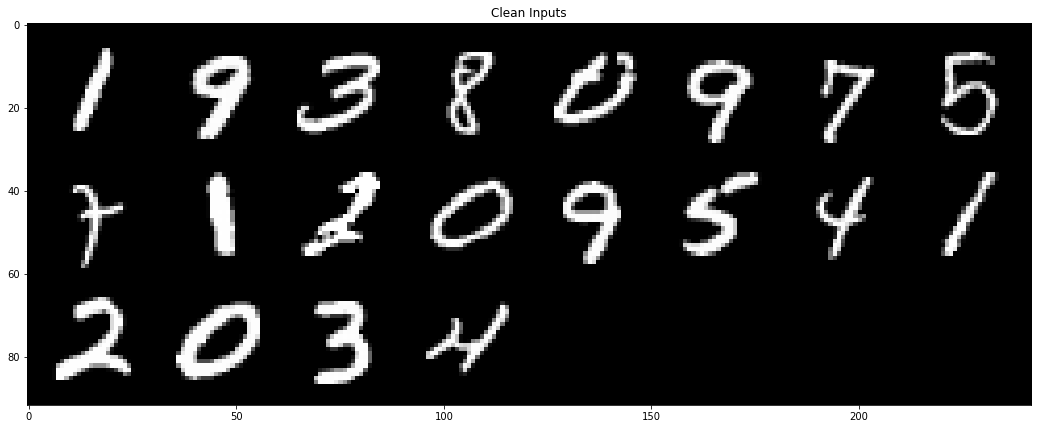

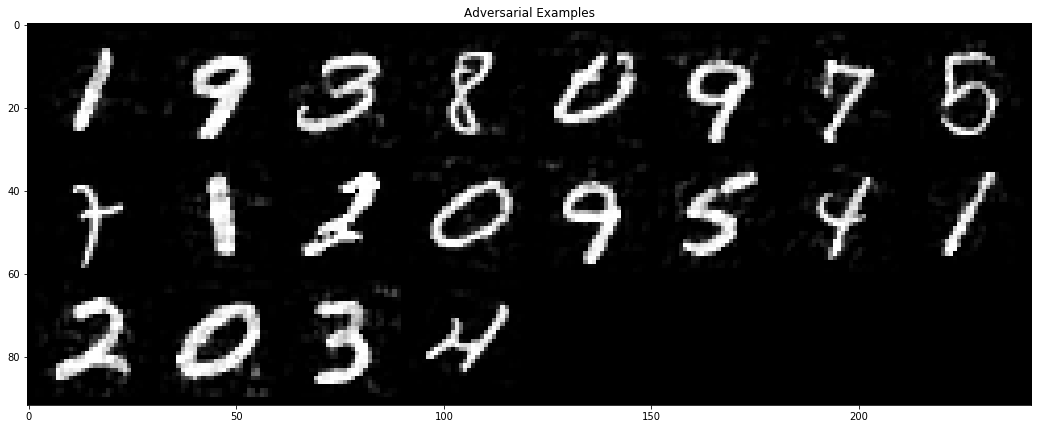

In [25]:
print(full_l2_np.shape)
print(full_label_np.shape)
print(full_pred_np.shape)
print(full_input_np.shape)
print(full_adv_np.shape)

images = torch.from_numpy(full_input_np)
plt.figure(figsize=[18, 18])
imshow(images, title='Clean Inputs')
plt.show()

advs = torch.from_numpy(full_adv_np)
plt.figure(figsize=[18, 18])
imshow(advs, title='Adversarial Examples')
plt.show()

In [26]:
# load results
saved_images = np.fromfile(open(IMAGE_FILE_PATH, 'rb'), dtype=np.float32)
saved_images = np.reshape(saved_images, full_input_np.shape)

saved_advs = np.fromfile(open(ADV_FILE_PATH, 'rb'), dtype=np.float32)
saved_advs = np.reshape(saved_advs, full_adv_np.shape)
assert saved_images.shape == saved_advs.shape

saved_l2 = np.fromfile(open(L2_FILE_PATH, 'rb'), dtype=np.float32)
assert saved_l2.shape == (NUM_ADV,)

saved_labels = np.fromfile(open(LABEL_FILE_PATH, 'rb'), dtype=np.int64)
assert saved_labels.shape == (NUM_ADV,)

saved_preds = np.fromfile(open(PRED_FILE_PATH, 'rb'), dtype=np.int64)
assert saved_preds.shape == (NUM_ADV,)

# check saved file
assert np.array_equal(saved_l2, full_l2_np)
assert np.array_equal(saved_labels, full_label_np)
assert np.array_equal(saved_preds, full_pred_np)
assert np.array_equal(saved_images, full_input_np)
assert np.array_equal(saved_advs, full_adv_np)
not_equal = np.not_equal(saved_labels, saved_preds)
assert len(not_equal[not_equal==True]) == len(not_equal)

In [27]:
print('NUM_ADV =', NUM_ADV)

# check saved results
data_clean = TensorDataset(
    torch.from_numpy(saved_images), 
    torch.from_numpy(saved_labels))
loader_clean = DataLoader(
    data_clean,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

data_adv = TensorDataset(
    torch.from_numpy(saved_advs), 
    torch.from_numpy(saved_labels))
loader_adv = DataLoader(
    data_adv,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

assert len(loader_clean.dataset) == NUM_ADV
assert len(loader_adv.dataset) == NUM_ADV

NUM_ADV = 20


In [28]:
va_loss, va_acc = validate(model, loader_clean)
print('Clean images - Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

Clean images - Loss: 0.0204 Accuracy: 100.0000%


In [29]:
va_loss, va_acc = validate(model, loader_adv)
print('Adversarial examples - Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

Adversarial examples - Loss: 0.7133 Accuracy: 0.0000%
